# Constructing twpas

This tutorial shows how to define and customize a TWPA model. At the moment, `twpasolver` is specialized to model KI-TWPAS only, but new components modeling the reposne of Josephson Junctions can be easily implemented.

### Using predefined models

Let's start by defining some parameters for the cells of the device. 
We consider a simple design with step modulation between a certain number of loaded and an unloaded cells.
We also define the circuit parameters for a mean effective TWPA without modulation, and compare the response of the devices. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numba import njit

from twpasolver.frequency import Frequencies
from twpasolver.models import TWPA, LCLfBaseCell, StubBaseCell

freqs = np.arange(1e9, 12e9, 2e6)
N_u = 60
N_l = 6
N_sc = 1000
N = N_sc * (N_u + N_l)

# Cell capacitances, expressed in F
C_u = 18.81e-15
C_l = 7.0e-15
C_eff = (N_u * C_u + N_l * C_l) / (N_u + N_l)

# Cell inductances, expressed in H
L_u = 45.2e-12
L_l = 45.2e-12
L_eff = (N_u * L_u + N_l * L_l) / (N_u + N_l)

# Finger inductances, expressed in H
L_f_u = 1.02e-9
L_f_l = 0.335e-9
L_f_eff = (N_u * L_f_u + N_l * L_f_l) / (N_u + N_l)

# Characteristic inductance
Z_0 = np.sqrt(L_u / C_u)
Z_l = np.sqrt(L_l / C_l)
Z_eff = np.sqrt(L_eff / C_eff)

l1_u = 102e-6
l1_l = 33.5e-6
l2 = 2e-6

We can now define the models for the cells and TWPAs. The `twpasolver.models.TWPA` class is derived from `twpasolver.models.TwoPortArray`, with additional arguments to represent the parameters of the nonlinear response, which will be used to find the phase-matching condition and the gain profile in the next tutorial. The `LCLfBaseCell` model determines the single cell response as detailed in Appendix B of [10.1103/PRXQuantum](https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.2.010302).

In [2]:
unloaded = LCLfBaseCell(C=C_u, L=L_u, Lf=L_f_u, N=N_u / 2)
loaded = LCLfBaseCell(C=C_l, L=L_l, Lf=L_f_l, N=N_l)
twpa = TWPA(cells=[unloaded, loaded, unloaded], N=N_sc)

# Effective mean cell and unmodulated TWPA
eff = LCLfBaseCell(C=C_eff, L=L_eff, Lf=L_f_eff, N=N_u + N_l)
twpa_not_loaded = TWPA(cells=[eff], N=N_sc)

twpa.model_dump()

{'Z0_ref': 50.0,
 'N': 1000,
 'cells': [{'Z0_ref': 50.0,
   'N': 30,
   'name': 'LCLfBaseCell',
   'L': 4.52e-11,
   'C': 1.881e-14,
   'Lf': 1.02e-09,
   'delta': 0.0,
   'centered': False},
  {'Z0_ref': 50.0,
   'N': 6,
   'name': 'LCLfBaseCell',
   'L': 4.52e-11,
   'C': 7e-15,
   'Lf': 3.35e-10,
   'delta': 0.0,
   'centered': False},
  {'Z0_ref': 50.0,
   'N': 30,
   'name': 'LCLfBaseCell',
   'L': 4.52e-11,
   'C': 1.881e-14,
   'Lf': 1.02e-09,
   'delta': 0.0,
   'centered': False}],
 'name': 'TWPA',
 'Istar': 0.0065,
 'Idc': 0.001,
 'Ip0': 0.0002,
 'N_tot': 66000,
 'epsilon': 46.242774566474,
 'xi': 23121.387283236996,
 'chi': 0.00011560693641618498,
 'alpha': 1.0236686390532543,
 'Iratio': 0.15384615384615385}

As usual, we plot the response of the devices, starting from the magnitude of $S_{21}$. The cell modulation creates a stopband.

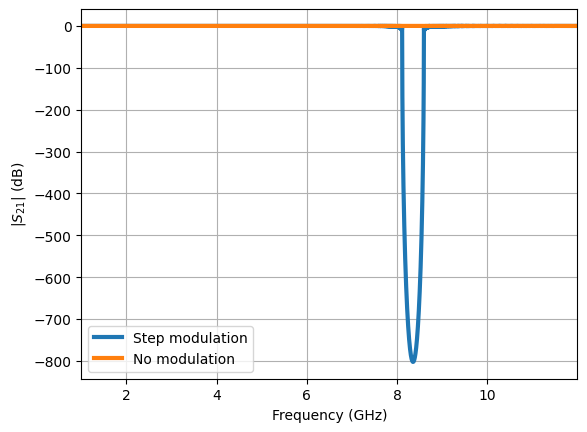

In [3]:
net = twpa.get_network(freqs)
net_unmodulated = twpa_not_loaded.get_network(freqs)

net.s21.plot_s_db(label="Step modulation", lw=3)
net_unmodulated.s21.plot_s_db(label="No modulation", lw=3)
plt.ylabel("$|S_{21}|$ (dB)")
plt.grid()

Another important aspect of the response of a TWPA is the nonlinear dependence of the phase of $S_{21}$.  The modulation creates a resonance-like profile that restricts the phase matching condition to a controllable range.

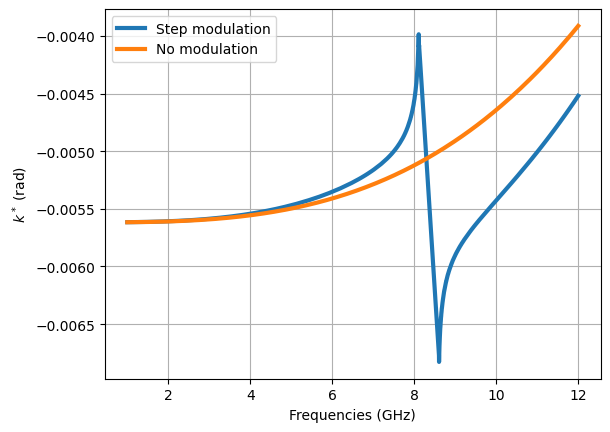

In [4]:
linear_disp = 2 * np.pi * freqs * np.sqrt(C_eff * L_eff)
plt.plot(
    freqs * 1e-9,
    -net.s21.s_rad_unwrap.flatten() / N - linear_disp,
    label="Step modulation",
    lw=3,
)
plt.plot(
    freqs * 1e-9,
    -net_unmodulated.s21.s_rad_unwrap.flatten() / N - linear_disp,
    label="No modulation",
    lw=3,
)
plt.xlabel("Frequencies (GHz)")
plt.ylabel("$k^*$ (rad)")
plt.legend()
plt.grid()

### Constructing models from basic components

It is also possible to explicitly use the composition of basic circuit elements to generate a TWPA. Here's how to repoduce the `LCLfBaseCell` model starting from inductors and capacitors.

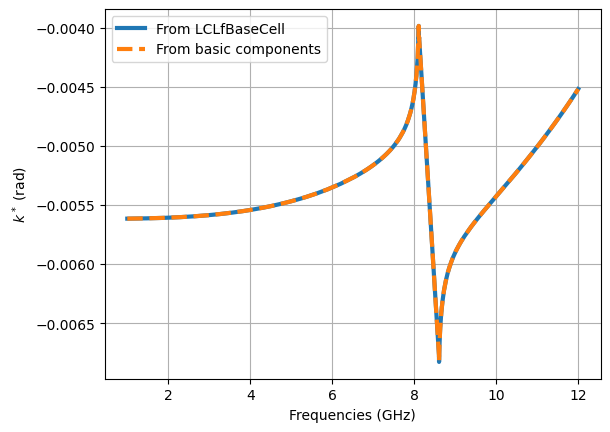

In [5]:
from twpasolver.models import Capacitance, Inductance, compose

L_line_u = Inductance(L=L_u)
fingers_u = compose(
    Capacitance(C=C_u / 2), Inductance(L=L_f_u), N=2, twoport_parallel=True
)
cell_u = compose(L_line_u, fingers_u, N=N_u / 2)

L_line_l = Inductance(L=L_l)
fingers_l = compose(
    Capacitance(C=C_l / 2), Inductance(L=L_f_l), N=2, twoport_parallel=True
)
cell_l = compose(L_line_l, fingers_l, N=N_l)

twpa_from_basic = TWPA(cells=[cell_u, cell_l, cell_u], N=N_sc)

# Plot the nonlinear phase response
plt.plot(
    freqs * 1e-9,
    -net.s21.s_rad_unwrap.flatten() / N - linear_disp,
    label="From LCLfBaseCell",
    lw=3,
)
plt.plot(
    freqs * 1e-9,
    -twpa_from_basic.get_network(freqs).s21.s_rad_unwrap.flatten() / N - linear_disp,
    label="From basic components",
    lw=3,
    ls="--",
)
plt.xlabel("Frequencies (GHz)")
plt.ylabel("$k^*$ (rad)")
plt.legend()
plt.grid()